In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from collections import Counter
import re
import spacy
from sklearn.linear_model import LinearRegression
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
df = pd.read_csv('/content/Og_ds.csv')
print(df.shape)

(649, 2)


In [ ]:
# Create a new column 'class_id' with encoded categories
df['class_id'] = df['Class'].factorize()[0]
category_id_df = df[['Class', 'class_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['class_id', 'Class']].values)

df.head(10)

,text,Class,class_id
0,"Like a lot of other touristic sites in France,...",Line Chart,0
1,One day Lisa decided to record the average tem...,Line Chart,0
2,Saima was planning a birthday party for her Gr...,Bar Chart,1
3,"A total of 8 prisoners were in cell 1, 9 peopl...",Bar Chart,1
4,Mrs Rehnuma gives online food delivery. Today ...,Pie Chart,2
5,"In 2020, the revenue generated by the tourism ...",Line Chart,0
6,3 employees at CERN rank their Compensation in...,Bar Chart,1
7,The report states sales have dropped from 2 % ...,Bar Chart,1
8,"The canal was 10 m deep and 35 m wide, with it...",Bar Chart,1
9,Coronaviruses are a group of RNA viruses that ...,Bar Chart,1


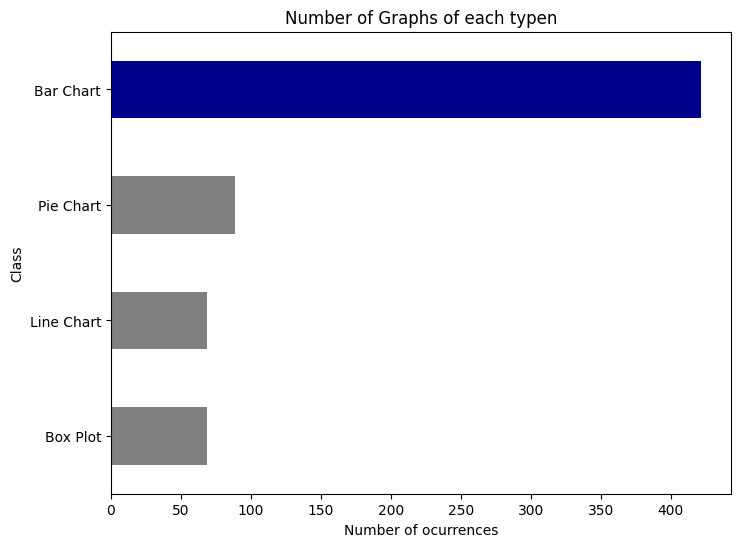

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','darkblue']
df.groupby('Class').text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Number of Graphs of each typen')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [ ]:
df['Class'].value_counts()

Bar Chart     422
Pie Chart      89
Line Chart     69
Box Plot       69
Name: Class, dtype: int64

In [ ]:
# Feature Extraction

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
features = tfidf.fit_transform(df.text).toarray()

X = features
y = df['class_id']

In [ ]:
#Train-Test split
#Countb of train-test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 296, 2: 66, 3: 47, 0: 45})
Testing target statistics: Counter({1: 126, 0: 24, 2: 23, 3: 22})


In [ ]:
#Balancing the training data

from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 296, 0: 296, 3: 296, 2: 296})
Testing target statistics: Counter({1: 126, 0: 24, 2: 23, 3: 22})


In [ ]:
#Model building

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

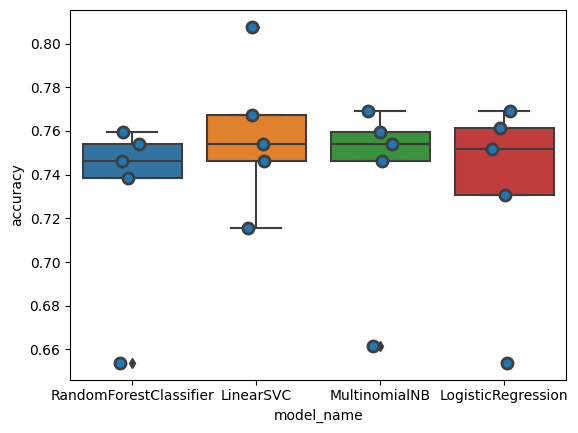

In [ ]:
#Analysing Accuraies

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
#Comparing the accuracies

cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.758104
LogisticRegression        0.733465
MultinomialNB             0.738092
RandomForestClassifier    0.730400
Name: accuracy, dtype: float64

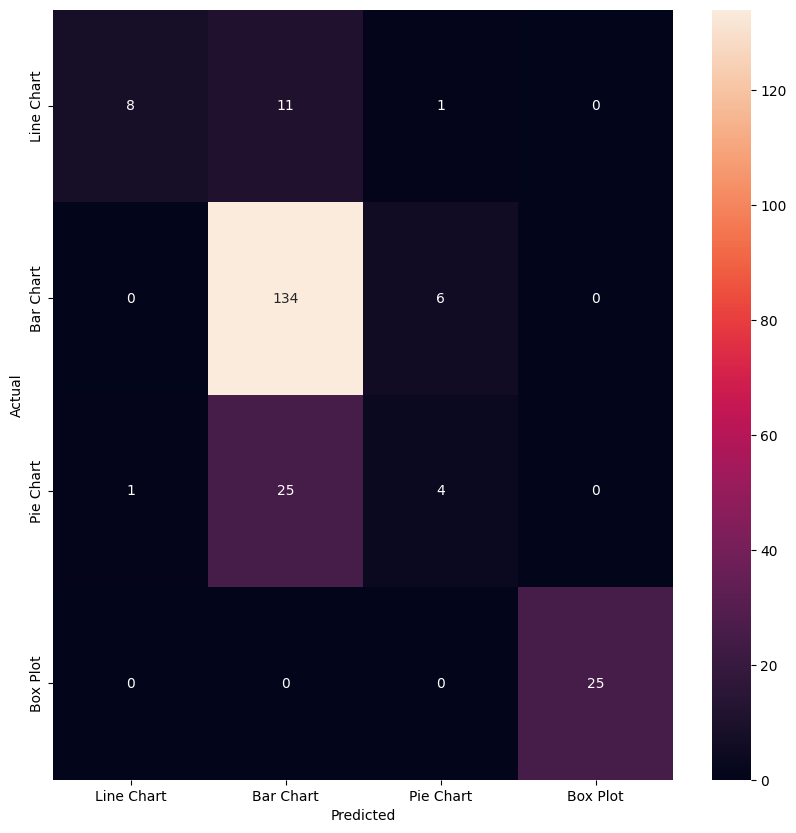

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, y, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Class.values, yticklabels=category_id_df.Class.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display
for predicted in category_id_df.class_id:
  for actual in category_id_df.class_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Class', 'text']])
      print('')

'Line Chart' predicted as 'Bar Chart' : 11 examples.


,Class,text
196,Line Chart,"Mahin is getting fatter year by year, this is ..."
1,Line Chart,One day Lisa decided to record the average tem...
573,Line Chart,Lack of pure drinking water is a major problem...
298,Line Chart,"Architects earned an average salary of $88,860..."
101,Line Chart,"From 2011 to 2017, Cristiano Ronaldo has been ..."
558,Line Chart,PlayerUnknown's Battlegrounds (PUBG) is one of...
404,Line Chart,"According to the World Bank, poverty in Pakist..."
332,Line Chart,Karim Chowdhury is a shop owner. About 20 type...
365,Line Chart,"At present, population growth is a burning que..."
0,Line Chart,"Like a lot of other touristic sites in France,..."



'Pie Chart' predicted as 'Bar Chart' : 25 examples.


,Class,text
534,Pie Chart,There are seven continents in this world. Each...
157,Pie Chart,Jupiter has 53 named moons and another 26 awai...
531,Pie Chart,Bangladesh National Cricket Team played 36 ODI...
64,Pie Chart,Here are the distribution of Starbucks stores ...
271,Pie Chart,Media outlets have pointed out not to rely on ...
449,Pie Chart,Ali's exams are knocking at the door. He needs...
235,Pie Chart,MI are the most successful team in the league'...
538,Pie Chart,The plinth and tomb took roughly 12 years to c...
252,Pie Chart,"Out of the total land area, 25 % is under cult..."
162,Pie Chart,Brian asks 80 people what their favourite colo...


In [ ]:
# Classification report

print('CLASSIFICATIION REPORT')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df['Class'].unique()))

CLASSIFICATIION REPORT
              precision    recall  f1-score   support

  Line Chart       0.89      0.40      0.55        20
   Bar Chart       0.79      0.96      0.86       140
   Pie Chart       0.36      0.13      0.20        30
    Box Plot       1.00      1.00      1.00        25

    accuracy                           0.80       215
   macro avg       0.76      0.62      0.65       215
weighted avg       0.76      0.80      0.76       215



In [ ]:
X = df['text']
y = df['Class']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [ ]:
print('Test accuracy:', accuracy)

Test accuracy: 0.751937984496124


['Bar Chart']


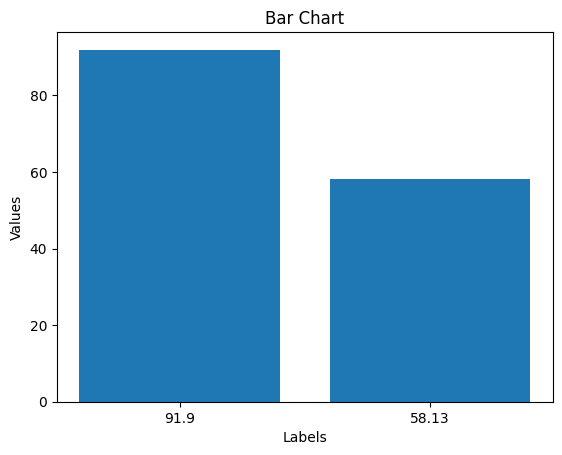

In [ ]:
text = 'The longest goal ever scored travelled a distance of 91.9 meters. The longest header was measured at 58.13 meters.'
prediction = (model.predict(fitted_vectorizer.transform([text])))
print(prediction)

# Create the graph.
if prediction == 'Bar Chart':

    def generate_bar_chart(sentence):
        # Split the sentence into words
        words = sentence.split()

        labels = []
        values = []

        # Perform part-of-speech tagging on the words
        tagged_words = pos_tag(words)

        # Iterate over the tagged words to extract labels and values
        i = 0
        while i < len(tagged_words):
            word, pos = tagged_words[i]

            # Check if the word is a numeric value
            if re.match(r'^-?\$?\d+(\.\d+)?[%$]?$', word):
                # Look for the next proper or common noun
                j = i + 1
                while j < len(tagged_words):
                    next_word, next_pos = tagged_words[j]
                    if next_pos.startswith('NN'):
                        break
                    j += 1

                # If there is no noun after the value, treat the value as the label
                if j == len(tagged_words):
                    label = word
                    # Remove any non-numeric characters from the word
                    value_word = re.sub(r'[^-.\d]', '', word)
                    value = float(value_word)
                else:
                    # Get the label by joining the words between i and j
                    label = ' '.join([w for w, _ in tagged_words[i:j]])
                    # Remove any non-numeric characters from the word
                    value_word = re.sub(r'[^-.\d]', '', word)
                    value = float(value_word)

                labels.append(label)
                values.append(value)

                # Update the index to the next word after the noun
                i = j

            else:
                i += 1

        # Generate bar chart
        plt.bar(labels, values)
        plt.xlabel('Labels')
        plt.ylabel('Values')
        plt.title('Bar Chart')

        # Show the plot
        plt.show()

    # Example usage
    bar_sentence = text
    generate_bar_chart(bar_sentence)


elif prediction == 'Line Chart':
# Load the spaCy English model
    nlp = spacy.load('en_core_web_sm')

    def extract_Ldata(sentence):
        pattern = r'(\d+(?:\.\d+)?)\s*(?:billion|million|billions|millions|lakhs|thousand|thousands|lakh|hundred|kg|pounds|grams|ounces|tonnes|%)?(?:\s+in)?\s+([a-zA-Z-]+(?:\s+[a-zA-Z-]+)*)'
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        values = []
        for match in matches:
            numeric_value = match[0]
            values.append(float(numeric_value))
        return values

    def generate_line_chart(data):
        x = np.arange(len(data))
        x = x[:, np.newaxis]
        print(x)
        print(data)
        model = LinearRegression()
        model.fit(x, data)
        # y_pred = model.predict(x)
        plt.plot(x, data, marker='o', label='Value')
        # plt.plot(x, y_pred, linestyle='--', label='Trendline')
        plt.xlabel('X Label')
        plt.ylabel('Y label')
        plt.title('Line Chart')
        plt.legend()
        plt.show()

    line_chart_sentence = text
    data = extract_Ldata(line_chart_sentence)
    generate_line_chart(data)

elif prediction == 'Box Plot':
    def extract_boxplot_data(sentence):
        data_matches = re.findall(r"([\w\s]+):\s*([\d\s,]+);?", sentence)
        data = {}
        for match in data_matches:
            key = match[0].strip()
            values = [int(val.strip()) for val in match[1].split(',') if val.strip()]
            if values:
                data[key] = values
        return data

    def generate_box_plot(data):
        plt.boxplot(data.values())
        plt.xticks(range(1, len(data) + 1), data.keys())
        plt.xlabel('Categories')
        plt.ylabel('Values')
        plt.title('Box Plot')
        plt.show()

    boxplot_sentence = text
    data = extract_boxplot_data(boxplot_sentence)
    generate_box_plot(data)


elif prediction == 'Pie Chart':
    nlp = spacy.load('en_core_web_sm')

    def extract_Pdata(sentence):
        pattern =r'\b(\d+(?:,\d+)?)%\s+(?:\b(?:of|to|reported|prefer|got|account|for|comprising)\s+)?(\w+(?:\s+\w+)*)'
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        data = [float(match[0].replace(',', '')) for match in matches]
        labels = [match[1] for match in matches]
        return data, labels

    def generate_pie_chart(data, labels):
        plt.pie(data, labels=labels, autopct='%1.1f%%')
        plt.title('Pie Chart')
        plt.show()

    def process_pie_chart_sentence(sentence):
        doc = nlp(sentence)
        data = []
        labels = []
        numerical_value = None
        for token in doc:
            if token.like_num:
                numerical_value = float(token.text.replace(',', ''))
            elif numerical_value and token.pos_ in ['NOUN', 'PROPN'] and token.text != '%':
                data.append(numerical_value)
                labels.append(token.text)
                numerical_value = None
        return data, labels

    pie_chart_sentence = text
    data, labels = process_pie_chart_sentence(pie_chart_sentence)

    if not data or not labels:
        data, labels = extract_Pdata(pie_chart_sentence)
    generate_pie_chart(data, labels)

# Show the graph.
plt.show()

['Box Plot']


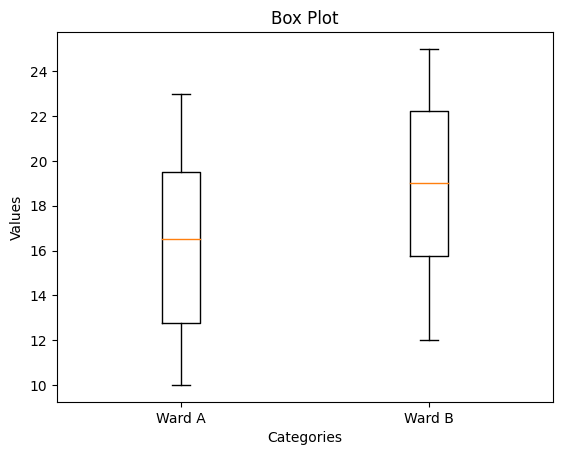

In [ ]:
text = 'A hospital recorded the number of patients admitted each day for two different wards: Ward A and Ward B. The results were: Ward A: 10, 12, 15, 18, 20, 23; Ward B: 12, 15, 18, 20, 23, 25.'
prediction = (model.predict(fitted_vectorizer.transform([text])))
print(prediction)

# Create the graph.
if prediction == 'Bar Chart':

    def generate_bar_chart(sentence):
        # Split the sentence into words
        words = sentence.split()

        labels = []
        values = []

        # Perform part-of-speech tagging on the words
        tagged_words = pos_tag(words)

        # Iterate over the tagged words to extract labels and values
        i = 0
        while i < len(tagged_words):
            word, pos = tagged_words[i]

            # Check if the word is a numeric value
            if re.match(r'^-?\$?\d+(\.\d+)?[%$]?$', word):
                # Look for the next proper or common noun
                j = i + 1
                while j < len(tagged_words):
                    next_word, next_pos = tagged_words[j]
                    if next_pos.startswith('NN'):
                        break
                    j += 1

                # If there is no noun after the value, treat the value as the label
                if j == len(tagged_words):
                    label = word
                    # Remove any non-numeric characters from the word
                    value_word = re.sub(r'[^-.\d]', '', word)
                    value = float(value_word)
                else:
                    # Get the label by joining the words between i and j
                    label = ' '.join([w for w, _ in tagged_words[i:j]])
                    # Remove any non-numeric characters from the word
                    value_word = re.sub(r'[^-.\d]', '', word)
                    value = float(value_word)

                labels.append(label)
                values.append(value)

                # Update the index to the next word after the noun
                i = j

            else:
                i += 1

        # Generate bar chart
        plt.bar(labels, values)
        plt.xlabel('Labels')
        plt.ylabel('Values')
        plt.title('Bar Chart')

        # Show the plot
        plt.show()

    # Example usage
    bar_sentence = text
    generate_bar_chart(bar_sentence)


elif prediction == 'Line Chart':
# Load the spaCy English model
    nlp = spacy.load('en_core_web_sm')

    def extract_Ldata(sentence):
        pattern = r'(\d+(?:\.\d+)?)\s*(?:billion|million|billions|millions|lakhs|thousand|thousands|lakh|hundred|kg|pounds|grams|ounces|tonnes|%)?(?:\s+in)?\s+([a-zA-Z-]+(?:\s+[a-zA-Z-]+)*)'
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        values = []
        for match in matches:
            numeric_value = match[0]
            values.append(float(numeric_value))
        return values

    def generate_line_chart(data):
        x = np.arange(len(data))
        x = x[:, np.newaxis]
        print(x)
        print(data)
        model = LinearRegression()
        model.fit(x, data)
        # y_pred = model.predict(x)
        plt.plot(x, data, marker='o', label='Value')
        # plt.plot(x, y_pred, linestyle='--', label='Trendline')
        plt.xlabel('X Label')
        plt.ylabel('Y label')
        plt.title('Line Chart')
        plt.legend()
        plt.show()

    line_chart_sentence = text
    data = extract_Ldata(line_chart_sentence)
    generate_line_chart(data)

elif prediction == 'Box Plot':
    def extract_boxplot_data(sentence):
        data_matches = re.findall(r"([\w\s]+):\s*([\d\s,]+);?", sentence)
        data = {}
        for match in data_matches:
            key = match[0].strip()
            values = [int(val.strip()) for val in match[1].split(',') if val.strip()]
            if values:
                data[key] = values
        return data

    def generate_box_plot(data):
        plt.boxplot(data.values())
        plt.xticks(range(1, len(data) + 1), data.keys())
        plt.xlabel('Categories')
        plt.ylabel('Values')
        plt.title('Box Plot')
        plt.show()

    boxplot_sentence = text
    data = extract_boxplot_data(boxplot_sentence)
    generate_box_plot(data)


elif prediction == 'Pie Chart':
    nlp = spacy.load('en_core_web_sm')

    def extract_Pdata(sentence):
        pattern =r'\b(\d+(?:,\d+)?)%\s+(?:\b(?:of|to|reported|prefer|got|account|for|comprising)\s+)?(\w+(?:\s+\w+)*)'
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        data = [float(match[0].replace(',', '')) for match in matches]
        labels = [match[1] for match in matches]
        return data, labels

    def generate_pie_chart(data, labels):
        plt.pie(data, labels=labels, autopct='%1.1f%%')
        plt.title('Pie Chart')
        plt.show()

    def process_pie_chart_sentence(sentence):
        doc = nlp(sentence)
        data = []
        labels = []
        numerical_value = None
        for token in doc:
            if token.like_num:
                numerical_value = float(token.text.replace(',', ''))
            elif numerical_value and token.pos_ in ['NOUN', 'PROPN'] and token.text != '%':
                data.append(numerical_value)
                labels.append(token.text)
                numerical_value = None
        return data, labels

    pie_chart_sentence = text
    data, labels = process_pie_chart_sentence(pie_chart_sentence)

    if not data or not labels:
        data, labels = extract_Pdata(pie_chart_sentence)
    generate_pie_chart(data, labels)

# Show the graph.
plt.show()

['Pie Chart']


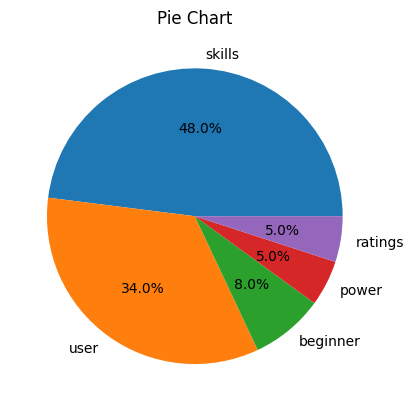

In [ ]:
text = 'Intermediate skills of 48 %, basic skills 34 %, advanced user 8 %, total beginner 5 % and power use 5 % were the ratings by the newly appointed employee in my company.'
prediction = (model.predict(fitted_vectorizer.transform([text])))
print(prediction)

# Create the graph.
if prediction == 'Bar Chart':

    def generate_bar_chart(sentence):
        # Split the sentence into words
        words = sentence.split()

        labels = []
        values = []

        # Perform part-of-speech tagging on the words
        tagged_words = pos_tag(words)

        # Iterate over the tagged words to extract labels and values
        i = 0
        while i < len(tagged_words):
            word, pos = tagged_words[i]

            # Check if the word is a numeric value
            if re.match(r'^-?\$?\d+(\.\d+)?[%$]?$', word):
                # Look for the next proper or common noun
                j = i + 1
                while j < len(tagged_words):
                    next_word, next_pos = tagged_words[j]
                    if next_pos.startswith('NN'):
                        break
                    j += 1

                # If there is no noun after the value, treat the value as the label
                if j == len(tagged_words):
                    label = word
                    # Remove any non-numeric characters from the word
                    value_word = re.sub(r'[^-.\d]', '', word)
                    value = float(value_word)
                else:
                    # Get the label by joining the words between i and j
                    label = ' '.join([w for w, _ in tagged_words[i:j]])
                    # Remove any non-numeric characters from the word
                    value_word = re.sub(r'[^-.\d]', '', word)
                    value = float(value_word)

                labels.append(label)
                values.append(value)

                # Update the index to the next word after the noun
                i = j

            else:
                i += 1

        # Generate bar chart
        plt.bar(labels, values)
        plt.xlabel('Labels')
        plt.ylabel('Values')
        plt.title('Bar Chart')

        # Show the plot
        plt.show()

    # Example usage
    bar_sentence = text
    generate_bar_chart(bar_sentence)


elif prediction == 'Line Chart':
# Load the spaCy English model
    nlp = spacy.load('en_core_web_sm')

    def extract_Ldata(sentence):
        pattern = r'(\d+(?:\.\d+)?)\s*(?:billion|million|billions|millions|lakhs|thousand|thousands|lakh|hundred|kg|pounds|grams|ounces|tonnes|%)?(?:\s+in)?\s+([a-zA-Z-]+(?:\s+[a-zA-Z-]+)*)'
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        values = []
        for match in matches:
            numeric_value = match[0]
            values.append(float(numeric_value))
        return values

    def generate_line_chart(data):
        x = np.arange(len(data))
        x = x[:, np.newaxis]
        print(x)
        print(data)
        model = LinearRegression()
        model.fit(x, data)
        # y_pred = model.predict(x)
        plt.plot(x, data, marker='o', label='Value')
        # plt.plot(x, y_pred, linestyle='--', label='Trendline')
        plt.xlabel('X Label')
        plt.ylabel('Y label')
        plt.title('Line Chart')
        plt.legend()
        plt.show()

    line_chart_sentence = text
    data = extract_Ldata(line_chart_sentence)
    generate_line_chart(data)

elif prediction == 'Box Plot':
    def extract_boxplot_data(sentence):
        data_matches = re.findall(r"([\w\s]+):\s*([\d\s,]+);?", sentence)
        data = {}
        for match in data_matches:
            key = match[0].strip()
            values = [int(val.strip()) for val in match[1].split(',') if val.strip()]
            if values:
                data[key] = values
        return data

    def generate_box_plot(data):
        plt.boxplot(data.values())
        plt.xticks(range(1, len(data) + 1), data.keys())
        plt.xlabel('Categories')
        plt.ylabel('Values')
        plt.title('Box Plot')
        plt.show()

    boxplot_sentence = text
    data = extract_boxplot_data(boxplot_sentence)
    generate_box_plot(data)


elif prediction == 'Pie Chart':
    nlp = spacy.load('en_core_web_sm')

    def extract_Pdata(sentence):
        pattern =r'\b(\d+(?:,\d+)?)%\s+(?:\b(?:of|to|reported|prefer|got|account|for|comprising)\s+)?(\w+(?:\s+\w+)*)'
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        data = [float(match[0].replace(',', '')) for match in matches]
        labels = [match[1] for match in matches]
        return data, labels

    def generate_pie_chart(data, labels):
        plt.pie(data, labels=labels, autopct='%1.1f%%')
        plt.title('Pie Chart')
        plt.show()

    def process_pie_chart_sentence(sentence):
        doc = nlp(sentence)
        data = []
        labels = []
        numerical_value = None
        for token in doc:
            if token.like_num:
                numerical_value = float(token.text.replace(',', ''))
            elif numerical_value and token.pos_ in ['NOUN', 'PROPN'] and token.text != '%':
                data.append(numerical_value)
                labels.append(token.text)
                numerical_value = None
        return data, labels

    pie_chart_sentence = text
    data, labels = process_pie_chart_sentence(pie_chart_sentence)

    if not data or not labels:
        data, labels = extract_Pdata(pie_chart_sentence)
    generate_pie_chart(data, labels)

# Show the graph.
plt.show()

['Line Chart']


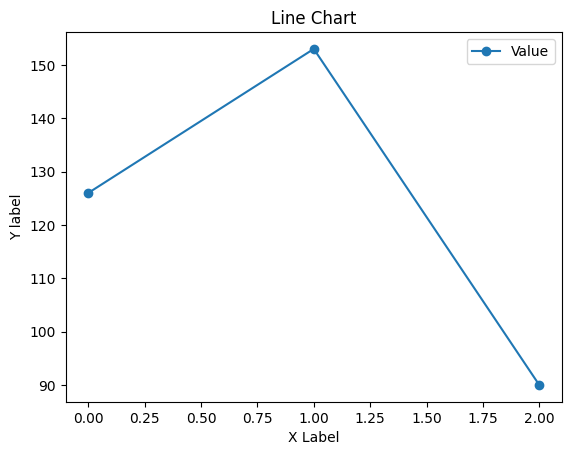

In [ ]:
text="In 2016, users spent 126 minutes per day on social media. It's estimated that we spend 153 minutes per day on social media in 2019. In 2012, the average was 90 minutes daily."
prediction = (model.predict(fitted_vectorizer.transform([text])))
print (prediction)

# Create the graph.
if prediction == 'Bar Chart':

    def generate_bar_chart(sentence):
        # Split the sentence into words
        words = sentence.split()

        labels = []
        values = []

        # Perform part-of-speech tagging on the words
        tagged_words = pos_tag(words)

        # Iterate over the tagged words to extract labels and values
        i = 0
        while i < len(tagged_words):
            word, pos = tagged_words[i]

            # Check if the word is a numeric value
            if re.match(r'^-?\$?\d+(\.\d+)?[%$]?$', word):
                # Look for the next proper or common noun
                j = i + 1
                while j < len(tagged_words):
                    next_word, next_pos = tagged_words[j]
                    if next_pos.startswith('NN'):
                        break
                    j += 1

                # If there is no noun after the value, treat the value as the label
                if j == len(tagged_words):
                    label = word
                    # Remove any non-numeric characters from the word
                    value_word = re.sub(r'[^-.\d]', '', word)
                    value = float(value_word)
                else:
                    # Get the label by joining the words between i and j
                    label = ' '.join([w for w, _ in tagged_words[i:j]])
                    # Remove any non-numeric characters from the word
                    value_word = re.sub(r'[^-.\d]', '', word)
                    value = float(value_word)

                labels.append(label)
                values.append(value)

                # Update the index to the next word after the noun
                i = j

            else:
                i += 1

        # Generate bar chart
        plt.bar(labels, values)
        plt.xlabel('Labels')
        plt.ylabel('Values')
        plt.title('Bar Chart')

        # Show the plot
        plt.show()

    # Example usage
    bar_sentence = text
    generate_bar_chart(bar_sentence)


elif prediction == 'Line Chart':
# Load the spaCy English model
    nlp = spacy.load('en_core_web_sm')

    def extract_Ldata(sentence):
        pattern = r'(\d+(?:\.\d+)?)\s*(?:billion|million|billions|millions|lakhs|thousand|thousands|lakh|hundred|kg|pounds|grams|ounces|tonnes|%)?(?:\s+in)?\s+([a-zA-Z-]+(?:\s+[a-zA-Z-]+)*)'
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        values = []
        for match in matches:
            numeric_value = match[0]
            values.append(float(numeric_value))
        return values

    def generate_line_chart(data):
        x = np.arange(len(data))
        x = x[:, np.newaxis]
        # print(x)
        # print(data)
        model = LinearRegression()
        model.fit(x, data)
        # y_pred = model.predict(x)
        plt.plot(x, data, marker='o', label='Value')
        # plt.plot(x, y_pred, linestyle='--', label='Trendline')
        plt.xlabel('X Label')
        plt.ylabel('Y label')
        plt.title('Line Chart')
        plt.legend()
        plt.show()

    line_chart_sentence = text
    data = extract_Ldata(line_chart_sentence)
    generate_line_chart(data)

elif prediction == 'Box Plot':
    def extract_boxplot_data(sentence):
        data_matches = re.findall(r"([\w\s]+):\s*([\d\s,]+);?", sentence)
        data = {}
        for match in data_matches:
            key = match[0].strip()
            values = [int(val.strip()) for val in match[1].split(',') if val.strip()]
            if values:
                data[key] = values
        return data

    def generate_box_plot(data):
        plt.boxplot(data.values())
        plt.xticks(range(1, len(data) + 1), data.keys())
        plt.xlabel('Categories')
        plt.ylabel('Values')
        plt.title('Box Plot')
        plt.show()

    boxplot_sentence = text
    data = extract_boxplot_data(boxplot_sentence)
    generate_box_plot(data)


elif prediction == 'Pie Chart':
    nlp = spacy.load('en_core_web_sm')

    def extract_Pdata(sentence):
        pattern =r'\b(\d+(?:,\d+)?)%\s+(?:\b(?:of|to|reported|prefer|got|account|for|comprising)\s+)?(\w+(?:\s+\w+)*)'
        matches = re.findall(pattern, sentence, re.IGNORECASE)
        data = [float(match[0].replace(',', '')) for match in matches]
        labels = [match[1] for match in matches]
        return data, labels

    def generate_pie_chart(data, labels):
        plt.pie(data, labels=labels, autopct='%1.1f%%')
        plt.title('Pie Chart')
        plt.show()

    def process_pie_chart_sentence(sentence):
        doc = nlp(sentence)
        data = []
        labels = []
        numerical_value = None
        for token in doc:
            if token.like_num:
                numerical_value = float(token.text.replace(',', ''))
            elif numerical_value and token.pos_ in ['NOUN', 'PROPN'] and token.text != '%':
                data.append(numerical_value)
                labels.append(token.text)
                numerical_value = None
        return data, labels

    pie_chart_sentence = text
    data, labels = process_pie_chart_sentence(pie_chart_sentence)

    if not data or not labels:
        data, labels = extract_Pdata(pie_chart_sentence)
    generate_pie_chart(data, labels)

# Show the graph.
plt.show()